# Course Project: Bayesian predictor selection

**Laia Domingo Colomer**<br>
**Núria Sánchez Font**

The notebook is structured as follows.

+ [$\text{1. Regression}$](#Reg)
+ [$\text{2. Classification}$](#Class)
+ [$\text{3. Experiments I: Regression}$](#ExpReg)
    + [$\text{Criterion 1: Cross-validation}$](#CVreg)
    + [$\text{Criterion 2: Widely applicable information criterion (WAIC)}$](#waicReg)
    + [$\text{Criterion 3: $L^2$ model approach}$](#L2reg)   
    + [$\text{Criterion 4: Reference model approach}$](#refReg)
+ [$\text{4. Experiments II: Classification}$](#ExpClass)
    + [$\text{Criterion 1: Cross-validation}$](#CVclass)
    + [$\text{Criterion 2: Widely applicable information criterion (WAIC)}$](#waicClass)
    + [$\text{Criterion 3: $L^2$ model approach}$](#L2class)
    + [$\text{Criterion 4: Reference model approach}$](#refClass)
+ [$\text{5. Analysis of the results}$](#AnalysisResults)
    + [$\text{Selected variables}$](#SelVariables)
    + [$\text{Performance}$](#Performance)
   
In [Section 1](#Reg) and [Section 2](#Class), we construct all the functions that will be required when performing the experiments. That is, the functions to simulate the data, to construct and fit the models (by means of stan or rstanarm) and to get the posterior probabilities. [Section 1](#Reg) regards the regression task and [Section 2](#Class) the classification task.

Then, in [Section 3](#ExpReg) and [Section 4](#ExpClass), we will implement the different criteria for the regression and classification tasks respectively. In the former, the methods will be implemented by means of the stan framework as well as analytically. 

Finally, [Section 5](#AnalysisResults) provides a summary of the results obtained in the experiments. That is, we show the variables selected by each of the methods as well as their performance. Despite the fact that we show such results, we do not comment them on the notebook but on the written memory. 

Let us mention that, although we make some comments along the notebook, all the conclusions extracted from the different experiments carried out can be found on the written report. 

## 1. Regression <a name="Reg" ></a>

We will consider both regression and classification problems.


### Data simulation

The simulated data is distributed as follows:

$$
x \sim N(0,R), \quad R \in \mathbb{R}^{p\times p}
$$

$$
y|x \sim N(\omega^Tx, \sigma^2), \quad \sigma^2=1
$$

Where $p$ is the total number of variables (we use $p=30$), $\omega$ are the weights and $R$ is the correlation matrix. 

The variables are separated in groups of 5. In each group, $x_j$ has mean zero, variance 1, and correlation $\rho$ with the other variables of the group. $x_j$ is uncorrelated with the variables outside this group. This means that the correlation matrix $R$ is of the form:

$$
R = \begin{pmatrix} 
  \tilde{R}     & 0 & \cdots & 0\\ 
  0 & \tilde{R} & \cdots & 0\\
  \vdots & \cdots & \tilde{R} & 0 \\
  0 & \cdots & \cdots & \tilde{R}
\end{pmatrix}, \quad \tilde{R} = 
\begin{pmatrix}
1 & \rho & \rho & \rho & \rho\\
\rho & 1 & \rho & \rho & \rho \\
\rho & \rho & 1 & \rho & \rho \\
\rho & \rho & \rho & 1 & \rho \\
\rho & \rho & \rho & \rho & 1 
\end{pmatrix}
$$

The weights are of the form:

$$
\begin{pmatrix}
\omega^{1:5}\\
\omega^{6:10}\\
\omega^{11:15}\\
\omega^{16:p}
\end{pmatrix} = 
\begin{pmatrix}
\chi\\
0.5\chi\\
0.25\chi\\
0
\end{pmatrix}
$$

Where $\omega^{1:5}$ denotes the weights of variables $x_1, \cdots, x_5$. That is, there are 15 variables which are informative to the variable $y$, and $p-15$ variables which are uninformative. 

We perform an experiment with the following training size and the correlation coefficient:

$$
n  =  100 \\
p  = 30\\
\rho = 0.5\\
\chi = 0.34
$$

In [1]:
library(MASS)

In [2]:
simulate.regression<-function(n, rho, chi, p=100){
    sigma2<-1
    mu<-rep(0,p)
    
    # Define R-tilde matrix
    Rt<- matrix(rep(rho, 5*5), ncol=5)
    diag(Rt)<-rep(1,5)

    # Define R matrix
    R <- matrix(0, ncol=p, nrow=p)
    for(i in seq(1,p,5)){
        R[i:(i+4), i:(i+4)] <- Rt
    }

    # Define weights
    w<-matrix(0, ncol=1, nrow=p)
    w[1:5,1]<-chi
    w[6:10,1]<-chi*0.5
    w[11:15,1]<-chi*0.25

    # Generate x observations
    x<-mvrnorm(n, mu, R)

    # Generate y observations (given x)
    y<-rnorm(n, x%*%w, sigma2)
    
    return(list('x' = x,'y' = y))
}

In [3]:
# Example simulation experiment
# Define parameters
n <- 100
rho <- 0.5
p <- 20
chi <- 0.34

# Simulate observations
sim<-simulate.regression(n, rho, chi, p)
x<-sim$x
y<-sim$y

### Build model

Now that we have simulated the observations, we will fit a linear regression. We will consider the standard Gaussian model:

$$
y|x, \omega, \sigma^2 \sim N(\omega^Tx, \sigma^2)\\
\omega | \sigma^2 \sim N(0, \sigma^2 \mathbb{1})\\
\sigma^2 \sim \text{Inv-Gamma}(\alpha, \beta)\\
$$

In this case we will use $\alpha = \beta =0.5$, and we assume that $x$ includes the intercept. We will fit this model using two approaches: by deriving analytically the posterior distribution and using Stan.



### Formulating the model analytically

The regression model using a normal-inverse-gamma (NIG) prior is a conjugate model. Therefore, the posterior distribution and posterior predictive distribution can be obtained analytically. Here we describe the Bayesian model.

#### Prior

The prior distributions of $\omega$ and $\sigma^2$ are the following:

$$
\omega | \sigma^2 \sim N(0, \sigma^2 \mathbb{1})\\
\sigma^2 \sim \text{Inv-Gamma}(\alpha, \beta)\\
$$

Recall that the joint prior is of the form $p(\omega, \sigma^2) \propto p(\omega|\sigma^2)p(\sigma^2)$. Therefore, the joint prior $(\omega,\sigma^2)$ follows a normal-inverse-gamma (NIG) with parameters:

$$
(\omega,\sigma^2) \sim NIG(0,\mathbb{1},\alpha, \beta)
$$

Finally, the prior distribution of $\omega$ can be found by integrating out $\sigma^2$ from the joint distribution. After some algebra, the resulting prior for $\omega$ is a multivariate student $t$:

$$
\omega \sim MVT_\nu(0, \Sigma)
$$

where $\nu = 2\alpha$ and $\Sigma = \frac{\beta}{\alpha}\mathbb{1}$.

#### Likelihood

The likelihood for the targets $y$ is a normal distribution:
$$
y|x, \omega, \sigma^2 \sim N(\omega^Tx, \sigma^2)\\
$$

#### Posterior

The posterior distribution of the pair $(\omega,\sigma^2)$ can be derived using the Bayes formula:

$$
p(\omega, \sigma|y,x) = \frac{p(\omega, \sigma^2)p(y|\omega,\sigma, x)}{p(y)}
$$

The posterior probability is again a normal-inverse-gamma:

$$
(\omega, \sigma^2|y,x) \sim NIG(\mu^*,V^*,\alpha^*,\beta^*)
$$

with

$$
\mu^* = (\mathbb{1} + X^TX)^{-1}(X^Ty)\\
V^* = (\mathbb{1} + X^TX)^{-1}\\
\alpha^* = \alpha + n/2\\
\beta^* = \beta + \frac{1}{2}(y^Ty - {\mu^*}^T{V^*}^{-1}\mu^*)
$$

The marginal distributions are:

$$
\sigma^2|y,x \sim IG(\alpha^*, \beta^*)\\
\omega|y,x \sim MVT_{\nu^*}(\mu^*, \Sigma^*), \quad \nu^* = 2\alpha^*, \Sigma^* = \frac{\beta^*}{\alpha^*} V^*\\
\omega|\sigma^2,y,x \sim N(\mu^*, \sigma^2V^*)
$$

#### Posterior predictive

Given a new set of observations $\tilde{X}$, the probability distribution of the new targets $\tilde{y}$ follows a multivariate student t distribution:

$$
    \tilde{y}|x,y,\sigma^2, \omega \sim MVT_{2\alpha^*}\Big(\tilde{X}\mu^*, \frac{\beta^*}{\alpha^*}(\mathbb{1} + \tilde{X}V^*\tilde{X}^T)\Big)
$$

In [4]:
require('LaplacesDemon')
require(invgamma)

Loading required package: LaplacesDemon

Loading required package: invgamma


Attaching package: ‘invgamma’


The following objects are masked from ‘package:LaplacesDemon’:

    dinvchisq, dinvgamma, rinvchisq, rinvgamma




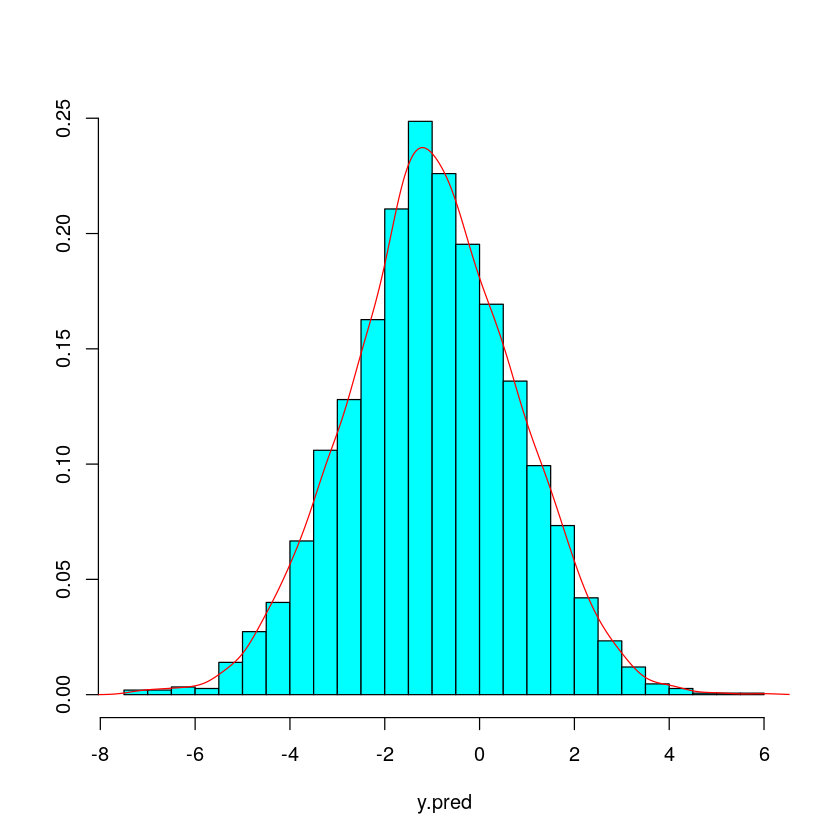

In [5]:
# Define parameters
n <- 100
rho <- 0.5
p <- 20
chi <- 0.34

# Initial parameters
alpha <- 0.5
beta <- 0.5
N<-3000

# Train and test data sets
# Train set
sim.train<-simulate.regression(n, rho, chi, p)
x.train<-sim.train$x
y.train<-sim.train$y
x.train.ext<-cbind(rep(1, dim(x.train)[2]),x.train)

# Test set
sim.test<-simulate.regression(N, rho, chi, p)
x.test<-sim.test$x
y.test<-sim.test$y
x.test.ext<-cbind(rep(1, dim(x.test)[2]),x.test)

# Posterior parameters
V.s<-round(solve(diag(p+1) + t(x.train.ext)%*%x.train.ext),10)
mu.s<-V.s%*%(t(x.train.ext)%*%y)
alpha.s<-alpha + n/2
beta.s<-as.numeric(beta + 1/2*(t(y)%*%y - t(mu.s)%*%solve(V.s)%*%mu.s))

# Sample from posterior 
sigma2.post<-rinvgamma(N,alpha.s,beta.s)
omega.post<- rmvt(N,mu.s, V.s, df=2*alpha.s)

# Sample from posterior predictive
new.x<-x.test.ext[1,]
new.mu<-new.x%*%mu.s
new.V<-beta.s/alpha.s*(diag(1) + t(new.x)%*%V.s%*%new.x)
y.pred<-rmvt(N, new.mu, new.V, df = 2*alpha.s)

# Get probability density posterior predictive
new.y<-as.matrix(seq(-10,10,0.001))
dens<-density(y.pred)
y.dens <- approx(dens$x,dens$y,xout=new.y)$y


truehist(y.pred)
lines(new.y, y.dens, col="red")

In [6]:
fit.reg.analytical<-function(x.train, y.train, alpha, beta, extended=FALSE){
    p<-dim(x.train)[2]
    if(!extended){
        x.train.ext<-cbind(dim(x.train)[1],x.train)
        p<-p+1
    }
    else{
        x.train.ext<-x.train
    }
    # Posterior parameters
    V.s<-round(solve(diag(p) + t(x.train.ext)%*%x.train.ext),10)
    mu.s<-V.s%*%(t(x.train.ext)%*%y.train)
    alpha.s<-alpha + n/2
    beta.s<-as.numeric(beta + 1/2*(t(y.train)%*%y.train - t(mu.s)%*%solve(V.s)%*%mu.s))
    return(list(V.s =V.s, mu.s = mu.s, alpha.s = alpha.s, beta.s = beta.s))

}


get.y.distr.reg.anal<-function(x.new, V.s, mu.s, alpha.s, beta.s, extended = FALSE){
    # Sample from posterior predictive
    if(!extended){
        x.new.ext<-rbind(1,x.new)
    }
    else{
        x.new.ext<-x.new
    }
    new.mu<-t(x.new.ext)%*%mu.s
    new.V<-beta.s/alpha.s*(diag(1) + t(x.new.ext)%*%V.s%*%x.new.ext)
    y.pred<-rmvt(N, new.mu, new.V, df = 2*alpha.s)
    return(y.pred)
}   
    

get.prob.y.reg.anal<-function(x.new, V.s, mu.s, alpha.s, beta.s, probs, extended = FALSE){
    # Sample from posterior predictive
    if(!extended){
        x.new.ext<-rbind(1,x.new)
    }
    else{
        x.new.ext<-x.new
    }
    new.mu<-t(x.new.ext)%*%mu.s
    new.V<-beta.s/alpha.s*(diag(1) + t(x.new.ext)%*%V.s%*%x.new.ext)
    y.pred<-rmvt(N, new.mu, new.V, df = 2*alpha.s)

    # Get probability density posterior predictive
    new.y<-as.matrix(seq(-10,10,0.001))
    dens<-density(y.pred)
    y.dens <- approx(dens$x,dens$y,xout=probs)$y
    return(y.dens)
}

fit<-fit.reg.analytical(x.train, y.train, alpha, beta)
x.new<-as.matrix(x.test[1,])
probs<-seq(-5,5,0.01)
dens<-get.prob.y.reg.anal(x.new, fit$V.s, fit$mu.s, fit$alpha.s,fit$beta.s, probs)

### Formulating the model with Stan

In [8]:
modelString.reg = "
   data { 
      int<lower=1> n;   // total number of observations 
      vector[n] y;      // response variable 
      int<lower=1> p;  // number of effects 
      matrix[n,p+1] X;   // model matrix 
      real alphaS;    // alpha sigma^2
      real betaS;    // beta sigma^2
      } 
      
   transformed data {
      } 
      
   parameters { 
      vector[p+1] omega;     // linear regression weights
      real<lower=0> sigma;   // standard deviation y
      }

   transformed parameters { 
      } 
      
   model { 
      vector[n] mu; 
      mu = X * omega; 
      
      // priors
      omega  ~ normal(0,sigma);
      sigma ~ inv_gamma(alphaS, betaS);

      // likelihood 
      y ~ normal(mu, sigma); 
      } 
      
   generated quantities {
     vector[n] log_lik;
     for (i in 1:n) log_lik[i] = normal_lpdf(y[i] | X[i,]*omega, sigma);
      } 
"

### Generate data for the model


In [9]:
D <- data.frame(y, x)

X.model = model.matrix(y~. , data = D) # This function includes the intercept for the model

data.list <- with(D, list(y = y, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                             alphaS=0.5, betaS=0.5, alphaT=0.5, betaT=0.5))



### Fitting the model

In [10]:
#install.packages("rstan",dependencies=TRUE,repos= "https://cloud.r-project.org")
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



### Generate a sample from the posterior probability

In [11]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model(model_code=modelString.reg) 

# Generate posterior sample:
stanFit.post <- sampling(object=stanDso, data=data.list, chains=1, iter=10000, warmup=1500, thin=1, seed=101)


SAMPLING FOR MODEL '27651c36bb7331771f811f7cc1e512c6' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 1501 / 10000 [ 15%]  (Sampling)
Chain 1: Iteration: 2500 / 10000 [ 25%]  (Sampling)
Chain 1: Iteration: 3500 / 10000 [ 35%]  (Sampling)
Chain 1: Iteration: 4500 / 10000 [ 45%]  (Sampling)
Chain 1: Iteration: 5500 / 10000 [ 55%]  (Sampling)
Chain 1: Iteration: 6500 / 10000 [ 65%]  (Sampling)
Chain 1: Iteration: 7500 / 10000 [ 75%]  (Sampling)
Chain 1: Iteration: 8500 / 10000 [ 85%]  (Sampling)
Chain 1: Iteration: 9500 / 10000 [ 95%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.261495 seconds (Warm-up)
Chain 1:                1.47205

In [14]:
# Samples of all the variables
omega.post <- extract(stanFit.post, 'omega')$omega
sigma.post <- extract(stanFit.post, 'sigma')
sigma.post <- unlist(sigma.post, use.names=FALSE)

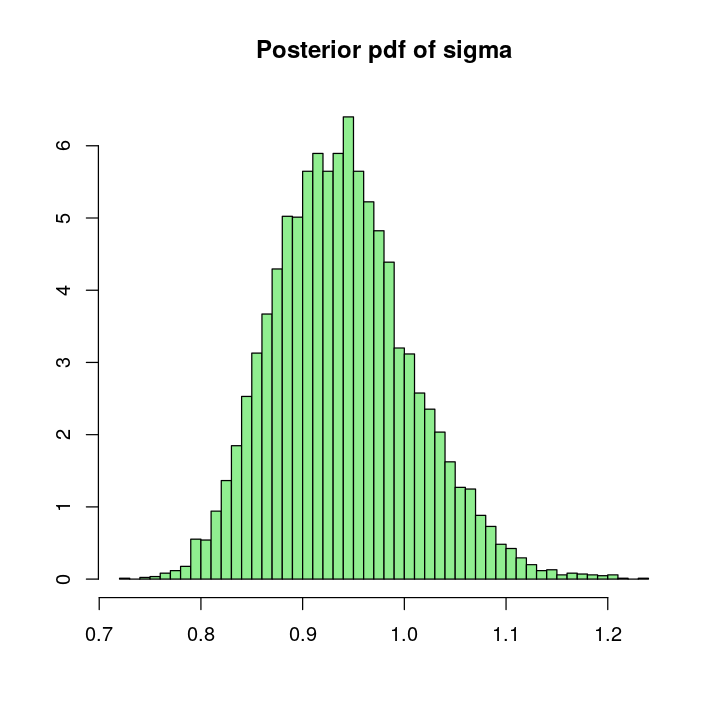

In [15]:
options(repr.plot.width=6,repr.plot.height=6)
hist(sigma.post,freq=FALSE,col="LightGreen",breaks=60,xlab="",ylab="",main="Posterior pdf of sigma")

### Obtain probability distribution of new observations

In [14]:
# Given a new observation x.new
sim.new<-simulate.regression(1, rho, chi, p)
x.new<-as.matrix(sim.new$x)
x.new.ext<-rbind(1,x.new)


# Generate the probability distribution y|x,omega,sigma,tau
# Draw samples of y from the likelihood, using the posterior parameters

get.y.distr<-function(x.new, omega.post, sigma.post){
    x.new.ext<-rbind(1,x.new)
    mu<-omega.post%*%x.new.ext
    sd<-sigma.post
    n.samp<-length(sigma.post)
    y.samp<-rnorm(n.samp, mu, sd)
    return(y.samp)
}

y.samp<-get.y.distr(x.new, omega.post, sigma.post)

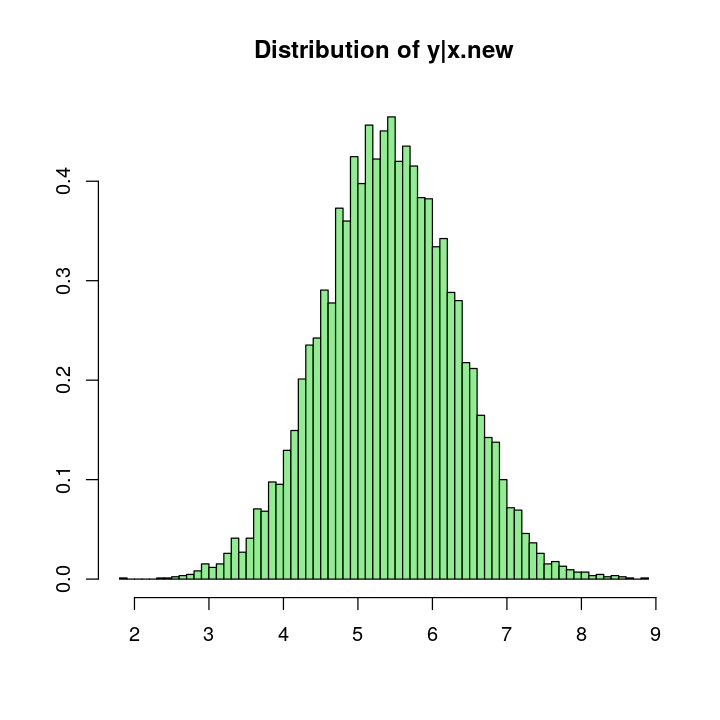

In [15]:
options(repr.plot.width=6,repr.plot.height=6)
hist(y.samp,freq=FALSE,col="LightGreen",breaks=60,xlab="",ylab="",main="Distribution of y|x.new")

## Putting it all together

The following function calculates a Bayesian Linear Regression, given an initial dataset and prior parameters. It returns the posterior quantities. These quantities can be used to generate the labels probability distribution $\tilde{y}|x,\omega,\sigma,\tau$. 


In [16]:
# Load Stan package
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

fit.linear.regression<-function(x,y,alphaS, betaS, modelString){
    # Create data for Stan
    D <- data.frame(y, x)
    X.model = model.matrix(y~. , data = D) # This function includes the intercept for the model
    data.list <- with(D, list(y = y, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                                 alphaS=alphaS, betaS=betaS))

    # Translate model to C++ and compile to DSO:
    stanDso <- stan_model(model_code=modelString)
    
    #Computing MAP estimators
    opt<-optimizing(stanDso, data=data.list)
    MAP<-opt$par
    l<-length(as.numeric(MAP))
    omega.MAP<-as.numeric(MAP)[1:l-1]
    sigma.MAP<-tail(as.numeric(MAP),1)

    # Generate posterior sample:
    stanFit.post<-sampling(object=stanDso,data=data.list,chains=3,iter=2000,warmup=1000,thin=1, seed =101)

    # Samples of all the variables
    omega.post <- extract(stanFit.post, 'omega')$omega
    sigma.post <- extract(stanFit.post, 'sigma')
    sigma.post <- unlist(sigma.post, use.names=FALSE)
    
    return(list(omega.post = omega.post,  sigma.post = sigma.post, omega.MAP = omega.MAP, sigma.MAP = sigma.MAP)) 
}


get.y.distr.reg<-function(x.new, omega.post, sigma.post){
    x.new.ext<-rbind(1,x.new)
    mu<-omega.post%*%x.new.ext
    sd<-sigma.post
    n.samp<-length(sigma.post)
    y.samp<-rnorm(n.samp, mu, sd)
    return(y.samp)
}


get.y.probs.reg<-function(x.new, omega.post, sigma.post, q){
    # q is the vector of quantiles to obtain the probabilities
    y.samp<-get.y.distr.reg(x.new, omega.post, sigma.post)
    dens<-density(y.samp)
    probs <- approx(dens$x,dens$y,xout=q)$y
    return(probs)
}

In [19]:
# Example

# Fit linear model and generate posterior quantities
linear.fit<-fit.linear.regression(x,y,0.5,0.5, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post

# New observation
sim.new<-simulate.regression(1, rho, chi, p)
x.new<-as.matrix(sim.new$x)

# Get probability density of different values of y
probs<-get.y.probs.reg(x.new, omega.post, sigma.post, seq(-4,4,0.1))
probs

[1] 7.719901e-03 1.030667e-02 1.338399e-02 1.717548e-02 2.221585e-02
 [6] 2.878946e-02 3.692960e-02 4.718366e-02 6.009194e-02 7.471670e-02
[11] 8.947528e-02 1.048422e-01 1.239765e-01 1.501470e-01 1.828671e-01
[16] 2.174470e-01 2.493151e-01 2.771188e-01 3.016158e-01 3.233962e-01
[21] 3.412763e-01 3.538552e-01 3.636771e-01 3.763722e-01 3.941254e-01
[26] 4.131208e-01 4.270867e-01 4.315257e-01 4.256884e-01 4.126562e-01
[31] 3.967732e-01 3.801405e-01 3.627263e-01 3.437259e-01 3.217373e-01
[36] 2.959422e-01 2.661601e-01 2.327675e-01 1.988633e-01 1.687478e-01
[41] 1.429616e-01 1.189527e-01 9.612446e-02 7.760279e-02 6.576107e-02
[46] 5.794738e-02 4.959607e-02 3.966175e-02 2.998898e-02 2.181651e-02
[51] 1.520126e-02 1.020348e-02 6.921781e-03 5.030402e-03 3.889539e-03
[56] 2.969924e-03 2.145447e-03 1.508344e-03 1.025174e-03 6.035917e-04
[61] 2.736276e-04 8.968569e-05 2.060806e-05           NA           NA
[66]           NA           NA           NA           NA           NA
[71]           NA           NA           NA           NA           NA
[76]           NA           NA           NA           NA           NA
[81]           NA

## 2. Classification model <a name="Class" ></a>

### Data simulation

The second type of models we are going to consider are Classification models. 
In this case, we will simulate binary data according to a logistic model. The data simulation process is the following:

$$
x \sim N(0,R), \quad R \in \mathbb{R}^{p\times p}
$$

$$
y|x \sim Ber(\text{inv_logit}(\omega^Tx))
$$

Where $R$ is the same correlation matrix as the one used in the regression problem, and $\text{inv_logit}$ is the inverse logit function. The weights $\omega$ and the parameters $n, \rho, \chi, p$ are the same as the ones used in the regression problem.

In [17]:
library(MASS)

simulate.classification<-function(n, rho, chi, p=100){
    mu<-rep(0,p)
    
    # Define R-tilde matrix
    Rt<- matrix(rep(rho, 5*5), ncol=5)
    diag(Rt)<-rep(1,5)

    # Define R matrix
    R <- matrix(0, ncol=p, nrow=p)
    for(i in seq(1,p,5)){
        R[i:(i+4), i:(i+4)] <- Rt
    }

    # Define weights
    w<-matrix(0, ncol=1, nrow=p)
    w[1:5,1]<-chi
    w[6:10,1]<-chi*0.5
    w[11:15,1]<-chi*0.25

    # Generate x observations
    x<-mvrnorm(n, mu, R)

    # Generate y observations (given x)
    y<-rbinom(n,1, invlogit(x%*%w))
    
    return(list('x' = x,'y' = y))
}

In [18]:
# Example simulation experiment
# Define parameters
n <- 100
rho <- 0.5
p <- 100
chi <- 0.34

# Simulate observations
sim<-simulate.classification(n, rho, chi, p)
x<-sim$x
y<-sim$y

### Build model

Now that we have simulated the observations, we will fit a generalized linear model. We will consider the standard logistic model:

$$
y|x, \omega \sim Ber(\text{inv_logit}(\omega^Tx))\\
\omega |  \tau^2 \sim N(0, \tau^2 \mathbb{I})\\
\tau^2 \sim \text{Inv-Gamma}(\alpha_\tau, \beta_\tau)
$$

In this case we will use $ \alpha_\tau = \beta_\tau =0.5$, and we assume that $x$ includes the intercept.

We will fit this model using Stan.

### Formulating the model

In [21]:
modelString.class = "
   data { 
      int<lower=1> n;   // total number of observations 
      int<lower=0,upper=1> y[n];      // response variable 
      int<lower=1> p;  // number of effects 
      matrix[n,p+1] X;   // model matrix 
      real alphaT;   // alpha tau^2
      real betaT;    // beta tau^2
      } 
      
   transformed data {
      } 
      
   parameters { 
      vector[p+1] omega;     // linear regression weights
      real<lower=0> tau; // standard deviation omega
      }

   transformed parameters { 
      } 
      
   model { 
      vector[n] mu; 
      mu = X * omega; 
      
      // priors
      omega  ~ normal(0,tau); 
      tau ~ inv_gamma(alphaT, betaT);

      // likelihood 
      y ~ bernoulli_logit(mu);

      } 
      
   generated quantities {
      } 
"

In [22]:
# Load Stan package
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

# Translate model to C++ and compile to DSO:
stanDso.class <- stan_model(model_code=modelString.class)     

fit.probit<-function(x,y, alphaT, betaT, stanDso){

    # Create data for Stan
    D <- data.frame(y, x)
    X.model = model.matrix(y~. , data = D) # This function includes the intercept for the model
    data.list <- with(D, list(y = y, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                               alphaT=alphaT, betaT=betaT))

    # Generate posterior sample:
    stanFit.post<-sampling(object=stanDso,data=data.list,chains=3,iter=10000,warmup=1500,thin=1, seed =101)

    # Samples of all the variables
    omega.post <- extract(stanFit.post, 'omega')$omega
    tau.post <- extract(stanFit.post, 'tau')
    tau.post <- unlist(tau.post, use.names=FALSE)

    return(list(omega.post = omega.post, tau.post = tau.post))    
}


get.y.distr.class<-function(x.new, omega.post){
    x.new.ext<-rbind(1,x.new)
    p<-pnorm(omega.post%*%x.new.ext)
    n.samp<-length(tau.post)
    y.samp<-rbinom(n.samp, 1, p)
    return(y.samp)
}


get.y.probs.class<-function(x.new, omega.post){
    y.samp<-get.y.distr.class(x.new, omega.post)
    p<-sum(y.samp)/length(y.samp)
    return(p)
}


In [41]:
# Example

# Fit linear model and generate posterior quantities
linear.fit<-fit.probit(x,y,0.5, 0.5, stanDso.class)
omega.post<-linear.fit$omega.post
tau.post<-linear.fit$tau.post

# New observation
sim.new<-simulate.classification(1, rho, chi, p)
x.new<-as.matrix(sim.new$x)

# Get probability density of different values of y
prob<-get.y.probs.class(x.new, omega.post)

prob

Warning message:
“There were 505 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


### Using rstanarm

Alternatively, we can use the rstanarm package to simulate the logistic model

In [23]:
require(rstanarm)
options(mc.cores = parallel::detectCores())

Loading required package: rstanarm

Loading required package: Rcpp

rstanarm (Version 2.19.3, packaged: 2020-02-11 05:16:41 UTC)

- Do not expect the default priors to remain the same in future rstanarm versions.

Thus, R scripts should specify priors explicitly, even if they are just the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

options(mc.cores = parallel::detectCores())

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘rstanarm’


The following object is masked from ‘package:rstan’:

    loo




In [24]:
fit.logit<-function(x.train, y.train, alpha, beta, return.cols = FALSE){
    D <- data.frame(y.train, x.train)
    t_prior <- student_t(df = 2*alpha, location = 0, scale = beta/alpha)

    post<-stan_glm(y.train~ ., data = D,
                 family = binomial(link = "logit"), 
                 prior = t_prior, prior_intercept = t_prior,
                 seed = 123)
    if(return.cols){
        return(list(post = post, names = colnames(D)))
    }
    return(post)
}


pred.prob.class<-function(D.test, model=post, draws=500){
    pred<-posterior_predict(model, D.test, draws = 500)
    p<-sum(pred)/length(pred)
    return(p)
}

## 3. Experiments I: Regression <a name="ExpReg" ></a>

In this section we will perform different experiments to perform variable selection in a linear regression problem. We will use different criteria, and assess the results.


### Utility function

The predictive performance of a model is typically defined in terms of a utility function that describes the quality of the predictions. An often used utility function measuring the quality of the predictive distribution of the candidate model M is the expected logarithmic score:

$$
u(M) = \mathbb{E}[log(p(\tilde{y}|M,D)] = \int p_t(\tilde{y}) log(p(\tilde{y}|M,D)) d\tilde{y}
$$

Where $D$ is the training dataset, $M$ is the chosen model, $\tilde{y}$ is a new target observation and $p_t(\tilde{y})$ is the true data generation distribution. 

A generalization of the utility function is the mean log predictive density (MLPD):

$$
MLPD = - \frac{1}{\tilde{n}} \sum_{i=1}^{\tilde{n}} log(p(\tilde{y}_i|\tilde{x}_i, D, M))
$$

Where $\{(\tilde{x}, \tilde{y})\}_{i=1}^\tilde{n}$ is the test set. In this case, the best model will be the one which **minimizes** the MLPD.

In [25]:
## Generate data

# Example
# Define parameters
n <- 100 #number of training data points
nt<-1000 #number of testing data points
rho <- 0.5
p <- 30
chi <- 0.34

# Simulate observations
# Train set
sim.train<-simulate.regression(n, rho, chi, p)
x.train<-sim.train$x
y.train<-sim.train$y

# Test set
sim.test<-simulate.regression(nt, rho, chi, p)
x.test<-sim.test$x
y.test<-sim.test$y

### With STAN

In [26]:
MLPD<-function(x.test, y.test, nt, sigma.post, omega.post){
    MLPD <- 0
    for(i in 1:nt){
        # Get probability density of different values of y
        p<-get.y.probs.reg(as.matrix(x.test[i,]), omega.post, sigma.post, y.test[i])
        MLPD<-MLPD + log(p)
    }
    MLPD<- - MLPD/nt
    return(MLPD)
}

In [27]:
# Get MLPD
# Fit linear model and generate posterior quantities
linear.fit<-fit.linear.regression(x.train,y.train,0.5,0.5, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post


performance<-MLPD(x.test, y.test, nt, sigma.post, omega.post)

performance

[1] 1.544819

### Analytically

In [28]:
MLPD.anal<-function(x.test, y.test, nt, V.s, mu.s, alpha.s, beta.s){
    MLPD <- 0
    for(i in 1:nt){
        # Get probability density of different values of y
        p<-get.prob.y.reg.anal(as.matrix(x.test[i,]), V.s, mu.s, alpha.s, beta.s, y.test[i])
        if(!is.na(p)){
          MLPD<-MLPD + log(p)   
        }
    }
    MLPD<- - MLPD/nt
    return(MLPD)
}

In [50]:
# Get MLPD
# Fit linear model 
fit<-fit.reg.analytical(x.train, y.train, alpha, beta)

performance<-MLPD.anal(x.test, y.test, nt, fit$V.s, fit$mu.s, fit$alpha.s, fit$beta.s)

performance


[1] 1.545591

## Optimization process

As a search heuristic we used the standard forward search, also known as the
stepwise regression. In other words, starting from the empty model, at each step we select the variable that increases the utility estimate (like CV, WAIC, DIC, etc.) the most.



In [29]:
optimization<-function(x.train, y.train, criteria, extended = TRUE){
    print("Starting optimization")
    D <- data.frame(y.train, x.train)
    if(extended){
        X.model = model.matrix(y.train~. , data = D)
    }
    else{
        X.model = x.train
    }
    num.vars<-dim(X.model)[2]
    all.vars<-seq(1,num.vars)
    var.list<-c(1)
    all.criteria<-c()
    best.vars<-var.list
    best.crit.val<-1000
    j<-0
    while(length(var.list)<num.vars){
        j<-j+1
        current.x.train<-as.matrix(X.model[,var.list])

        current.crit.val<-criteria(current.x.train, y.train)
        all.criteria<-c(all.criteria, current.crit.val)
        new.crit.vals<-c()
        sel.vars<-all.vars[-var.list]
        
        for(i in sel.vars){
            new.x.train<-as.matrix(X.model[,c(var.list,i)])
            new.crit.val<-criteria(new.x.train, y.train)
            new.crit.vals<-c(new.crit.vals,new.crit.val)
        }
        
        idx<-which.min(new.crit.vals)
        new.var<-sel.vars[idx]
        if(new.crit.vals[idx] < best.crit.val  ){
            best.vars<-c(var.list,new.var)
            best.crit.val<-new.crit.vals[idx]
        }
        var.list<-c(var.list,new.var)
        current.crit.val<-new.crit.vals[idx]
    }
    
    current.x.train<-as.matrix(X.model[,best.vars])
    print(best.vars)
    if(extended){
        return(list(model = current.x.train, num.vars = dim(current.x.train)[2]-1,
                    criteria = best.crit.val, all.criteria = all.criteria))
    }
    D <- data.frame(y.train, current.x.train)
    X.model = model.matrix(y.train~. , data = D)
    return(list(model = X.model, num.vars = dim(current.x.train)[2] -1 ,
                        criteria = best.crit.val, all.criteria = all.criteria))
}

## Criterion 1: Cross-validation <a name="CVreg" ></a>

The K-fold cross validation is an approximation of the utility function:

$$
K-fold-CV = - \frac{1}{n} \sum_{i=1}^n log(p(y_i|x_i, D_i, M)
$$

where $D_i$ is the training dataset without the point $(x_i, y_i)$ (and probably other sample points). 



### With Stan

In [30]:
library(caret)

k.fold.cv<-function(x.train, y.train, k.fold=10){
    set.seed(10)
    partitions<-createFolds(y.train, k = k.fold, list = TRUE, returnTrain = FALSE)
    cv<-0
    for(i in 1:k.fold){
        idx<-unlist(partitions[i])
        x.fold.in<-as.matrix(x.train[idx,])
        y.fold.in<-y.train[idx]
        x.fold.out<-as.matrix(x.train[-idx,])
        y.fold.out<-y.train[-idx]
        linear.fit<-fit.linear.regression(x.fold.out,y.fold.out,0.5,0.5, modelString.reg)
        omega.post<-linear.fit$omega.post
        sigma.post<-linear.fit$sigma.post
        
        for(j in 1:length(idx)){ 
            p<-get.y.probs.reg(as.matrix(x.fold.in[j,]), omega.post, sigma.post, y.fold.in[j])
            if(!is.na(p)){
                cv<-cv + log(p)
            }
        }
    }
    cv<- - cv/length(y.train)
    return(cv)
}

k.fold<-10

cv<-k.fold.cv(x.train, y.train, k.fold)

cv

Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:rstanarm’:

    compare_models, R2




[1] 1.545149

### Optimizing CV

In [345]:
opt<-optimization(x.train, y.train, k.fold.cv)

[1] "Starting optimization"
[1] 0
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13


In [350]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 13

[1] -1.455791

[1] "(Intercept)" "X3"          "X5"          "X6"          "X1"         
 [6] "X12"         "X9"          "X2"          "X8"          "X10"        
[11] "X17"         "X15"         "X20"         "X19"

In [420]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
linear.fit<-fit.linear.regression(x.train.model, y.train, alpha, beta, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post

performance<-MLPD(x.test.model, y.test, nt, sigma.post, omega.post)

performance

[1] 1.579814

### Analytically

In [171]:
library(caret)

k.fold.cv.anal<-function(x.train, y.train, k.fold=10, extended=TRUE){
    set.seed(10)
    partitions<-createFolds(y.train, k = k.fold, list = TRUE, returnTrain = FALSE)
    cv<-0
    for(i in 1:k.fold){
        idx<-unlist(partitions[i])
        x.fold.in<-as.matrix(x.train[idx,])
        y.fold.in<-y.train[idx]
        x.fold.out<-as.matrix(x.train[-idx,])
        y.fold.out<-y.train[-idx]
        fit<-fit.reg.analytical(x.fold.out, y.fold.out, alpha, beta, extended=extended)
        
        for(j in 1:length(idx)){ 
            p<-get.prob.y.reg.anal(as.matrix(x.fold.in[j,]), fit$V.s, 
                                   fit$mu.s, fit$alpha.s, fit$beta.s, 
                                   y.fold.in[j], extended = extended)
            if(!is.na(p)){
                cv<-cv + log(p)
            }
        }
    }
    cv<- - cv/length(y.train) # Negative sign because the optimization process looks for a minima 
    return(cv)
}

k.fold<-10

cv<-k.fold.cv.anal(x.train, y.train, k.fold, extended=FALSE)

cv

[1] 1.848086

In [198]:
opt<-optimization(x.train, y.train, k.fold.cv.anal)

[1] "Starting optimization"
[1]  1  6  4  2 16  5  9 13 22


In [199]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 8

[1] 1.58477

[1] "(Intercept)" "X5"          "X3"          "X1"          "X15"        
[6] "X4"          "X8"          "X12"         "X21"

In [200]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
fit<-fit.reg.analytical(x.train.model, y.train, alpha, beta)

performance<-MLPD.anal(x.test.model, y.test, nt, fit$V.s, fit$mu.s, fit$alpha.s, fit$beta.s)

performance

[1] 1.594188

## Criterion 2: Widely applicable information criterion (WAIC) <a name="waicReg" ></a>

Information criteria in another approach for estimating the generalization performance of the model. The widely applicable information criterion (WAIC) is computed as follows:

$$
\text{WAIC} =- \Big( \frac{1}{n}\sum_{i=1}^n \log p(y_i|x_i,D,M)-\frac{V}{n}\Big),
$$

where the first term is the training utility and $V$ is the functional variance given by

$$
V=\sum_{i=1}^n\left[\text{E}\left[(\log p(y_i|x_i,\theta,M))^2\right]-\text{E}[\log p(y_i|x_i,\theta,M)]^2\right].
$$

Here both of the expectations are taken over the posterior $p(\theta|D,M)$.

### With Stan

We first tried to implement the WAIC utility function, which can be seen in the next cell. However, it do not appeared to be a good option since it took too much time to execute. Therefore, we decided to use the already implemented function *waic* within the *loo* package. Since this function only applies over a fitted stan model, this criteria will only be computed by means of stan, thus the analytical way will be omitted. Actually, we could slightly modify the below cell in order to compute it on an analytical way, but, as we have already mentioned, its executation would take too long.

In [ ]:
#DO NOT RUN THIS CELL, SINCE IT TAKES TOO LONG TO EXECUTE
library(caret)

WAIC.model<-function(x.train, y.train, M=100){
    WAIC<-0
    linear.fit<-fit.linear.regression(x.train, y.train, alpha, beta, modelString.reg)
    omega.post<-linear.fit$omega.post
    sigma.post<-linear.fit$sigma.post 
    for(i in 1:n){
        p1<-get.y.probs.reg(as.matrix(x.train[i,]), omega.post, sigma.post, as.matrix(y.train[i]))
        aux<-rep(0,M)
        cont<-1
        for(j in 1:M){
            linear.fit<-fit.linear.regression(x.train, y.train, alpha, beta, modelString.reg)
            omega.post<-linear.fit$omega.post
            sigma.post<-linear.fit$sigma.post
            p2<-get.y.probs.reg(as.matrix(x.train[i,]), omega.post, sigma.post, as.matrix(y.train[i]))
            aux[cont]<-log(p2)
            cont<-cont+1
        }
        if(!is.na(p1)){
                WAIC<-WAIC + (log(p1) - var(aux))
            }               
    }
    WAIC<-WAIC/length(y.train)
    return(WAIC) 
}

WAIC<-WAIC.model(x.train, y.train)

WAIC

We redefine the *WAIC.model* function by using the *waic* function from the *loo* package:

In [31]:
library(loo)

WAIC.model<-function(x.train, y.train){
    options(mc.cores = parallel::detectCores())
    require(rstan)
    rstan_options(auto_write = TRUE)
    Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

    D <- data.frame(y.train, x.train)
    X.model = model.matrix(y.train~. , data = D) # This function includes the intercept for the model
    data.list <- with(D, list(y = y.train, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                             alphaS=alpha, betaS=beta))

    stanDso <- stan_model(model_code=modelString.reg)
    stanFit.post<-sampling(object=stanDso,data=data.list,chains=3,iter=2000,warmup=1000,thin=1, seed=101)
    
    log.lik<-extract_log_lik(stanFit.post, parameter_name='log_lik')
    waic<-waic(log.lik)
    
    return(waic$waic) 
}

WAIC<-WAIC.model(x.train, y.train)

WAIC

This is loo version 2.2.0

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 


Attaching package: ‘loo’


The following object is masked from ‘package:rstan’:

    loo


Warning message:
“
27 (27.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”


[1] 319.4005

In [32]:
opt<-optimization(x.train, y.train, WAIC.model)

[1] "Starting optimization"


Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the w

Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
3 (3.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 

Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release

Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release

Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
2 (2.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
3 (3.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
3 (3.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release

Warning message:
“
4 (4.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
3 (3.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
3 (3.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
5 (5.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release

Warning message:
“
4 (4.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
4 (4.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
3 (3.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
6 (6.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release

Warning message:
“
4 (4.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
5 (5.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
5 (5.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
6 (6.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release

Warning message:
“
6 (6.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
5 (5.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
7 (7.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
5 (5.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release

Warning message:
“
7 (7.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
7 (7.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
7 (7.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
6 (6.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release

Warning message:
“
9 (9.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
8 (8.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
10 (10.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
9 (9.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future relea

Warning message:
“
10 (10.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
12 (12.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
12 (12.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
11 (11.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future

Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
11 (11.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
12 (12.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
12 (12.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message

Warning message:
“
16 (16.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
16 (16.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
15 (15.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
15 (15.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future

Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
18 (18.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
18 (18.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
20 (20.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message

Warning message:
“
24 (24.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
24 (24.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
22 (22.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future release. Please extract the waic estimate from the 'estimates' component instead.”
Warning message:
“
24 (24.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“Accessing waic using '$' is deprecated and will be removed in a future

 [1]  1  4  9  5  2  8 10  3 29 16 19 26 25


In [33]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 12

[1] 288.8421

[1] "(Intercept)" "X3"          "X8"          "X4"          "X1"         
 [6] "X7"          "X9"          "X2"          "X28"         "X15"        
[11] "X18"         "X25"         "X24"

In [34]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
linear.fit<-fit.linear.regression(x.train.model, y.train, alpha, beta, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post

performance<-MLPD(x.test.model, y.test, nt, sigma.post, omega.post)

performance

[1] 1.537259

## Criterion 3: $L^2$ model approach <a name="L2reg" ></a>

The error measure can be decomposed as

$$
L^2=\sum_{i=1}^n \left(y_i-E[\tilde{y}|x_i,D,M]\right)^2 +\sum_{i=1}^n\text{VAR}[\tilde{y}|x_i,D,M],
$$

that is, as a sum of the squared errors for mean predictions plus sum of the predictive variances. The preferred model os the one that minimizes this expression.

### With Stan

In [66]:
library(caret)

L2.model<-function(x.train, y.train){
    L2<-0
    linear.fit<-fit.linear.regression(x.train, y.train, alpha, beta, modelString.reg)
    omega.post<-linear.fit$omega.post
    sigma.post<-linear.fit$sigma.post    
    for(i in 1:n){
        y<-get.y.distr.reg(as.matrix(x.train[i,]), omega.post, sigma.post)
        expectation<-mean(y)
        variance<-var(y)
        term<-(y.train[i]-expectation)^2+variance
        if(!is.na(term)){
            L2<-L2+term
        }
    }
    return(L2)
}

L2<-L2.model(x.train, y.train)

L2

[1] 150.8946

In [67]:
opt<-optimization(x.train, y.train, L2.model)

[1] "Starting optimization"
 [1]  1  4  6  8  5 13  3 27 10 15  2 30 22 20 31 24 11


In [68]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 16

[1] 141.8505

[1] "(Intercept)" "X3"          "X5"          "X7"          "X4"         
 [6] "X12"         "X2"          "X26"         "X9"          "X14"        
[11] "X1"          "X29"         "X21"         "X19"         "X30"        
[16] "X23"         "X10"

In [71]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
linear.fit<-fit.linear.regression(x.train.model, y.train, alpha, beta, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post

performance<-MLPD(x.test.model, y.test, nt, sigma.post, omega.post)

performance

[1] 1.556599

### Analytically

In [97]:
library(caret)

L2.model.anal<-function(x.train, y.train, extended=TRUE){
    L2<-0
    linear.fit<-fit.reg.analytical(x.train, y.train, alpha, beta, extended=extended)
    for(i in 1:n){
        y<-get.y.distr.reg.anal(as.matrix(x.train[i,]), linear.fit$V.s, linear.fit$mu.s,
                                linear.fit$alpha.s, linear.fit$beta.s, extended = extended)
        expectation<-mean(y)
        variance<-var(y)
        term<-(y.train[i]-expectation)^2+variance
        if(!is.na(term)){
            L2<-L2+term
        }
    }
    return(L2[1])
}

L2<-L2.model.anal(x.train, y.train, extended=FALSE)

L2

[1] 149.4941

In [99]:
opt<-optimization(x.train, y.train, L2.model.anal)

[1] "Starting optimization"
 [1]  1  4  6  8  5 13  3 30 10 15 20 27  2 31 22 24 11 29


In [100]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 17

[1] 142.9217

[1] "(Intercept)" "X3"          "X5"          "X7"          "X4"         
 [6] "X12"         "X2"          "X29"         "X9"          "X14"        
[11] "X19"         "X26"         "X1"          "X30"         "X21"        
[16] "X23"         "X10"         "X28"

In [103]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
fit<-fit.reg.analytical(x.train.model, y.train, alpha, beta)

performance<-MLPD.anal(x.test.model, y.test, nt, fit$V.s, fit$mu.s, fit$alpha.s, fit$beta.s)

performance

[1] 1.548075

## Criterion 4: Reference model approach <a name="refReg" ></a>

The idea of the reference model criteria is to construct a full encompassing reference model $M^∗$, which is believed to best describe our knowledge about the future observations, and perform the utility estimation almost as if it was the true data generating distribution.

Assuming we have constructed a reference model $M^∗$ which we believe best describes our knowledge about the future observations, the utilities of the candidate models $M$ can be estimated by replacing the true distribution $p_t(\tilde{y})$  by the predictive distribution of the reference model $p(\tilde{y} | D, M^∗)$. The maximization of the reference utility is equivalent to minimizing the predictive KL-divergence between the reference model $M^∗$ and the candidate model M at the training inputs:

$$
\delta(M||M^*) = \frac{1}{n}\sum_{i=1}^n KL(p(\tilde{y_i} | x_i, D, M^∗)||p(\tilde{y_i} | x_i, D, M))
$$

The model choice can then be based on the strict minimization of the discrepancy measure, or choosing the simplest model that has an acceptable discrepancy.

The reference predictive approach is inherently a less straightforward approach to model selection than the cross-validation criteria , because it requires the construction of the reference model and it is not obvious how it should be done.  Bayesian model average (BMA) has been commonly proposed as the reference model. In the variable selection context, the model averaging corresponds to a spike-and-slab type prior which is often considered as the “gold standard” and has been extensively used for linear models. The BMA approach is the following:

$$
p(\tilde{y}|D) = \sum_{l=1}^L p(\tilde{y}|D, M_l) p(M_l|D)
$$

where $p(\tilde{y}|D, M_l)$ is the posterior predictive distribution of a fitted model $M_l$ and $p(M_l|D)$ is the prior probability of the certain model $M_l$. 

The package BMS implements the Bayesian Model Average (BMS). We will use this package to generate the reference model.



### Bayesian model average (BMA)

In [188]:
require("BMS")

D <- data.frame(y.train, x.train)
bma<-bms(D, mprior = "random", burn = 20000, iter = 50000, user.int = FALSE)

Loading required package: BMS



Here we can see the statistics of the average model. The PIP quantity indicates the proportion of the models where a certain variable has been used. Variables with high PIP are believed to have hihger importance.

In [189]:
bma

        PIP    Post Mean    Post SD Cond.Pos.Sign Idx
X4  0.94816  0.592190011 0.21968565    1.00000000   4
X1  0.73258  0.435872739 0.30889318    1.00000000   1
X15 0.68272  0.320471312 0.25023250    1.00000000  15
X10 0.64808  0.277229825 0.23395556    1.00000000  10
X3  0.61206  0.272837266 0.25162061    1.00000000   3
X2  0.47104  0.226470542 0.27422147    1.00000000   2
X27 0.34638  0.103007077 0.16005459    1.00000000  27
X6  0.29652  0.109225513 0.19108309    1.00000000   6
X9  0.24826  0.092421700 0.18329052    1.00000000   9
X5  0.17348  0.062861460 0.16013769    1.00000000   5
X13 0.14800  0.040116280 0.11459366    1.00000000  13
X11 0.13960  0.035678314 0.10683060    0.99914040  11
X7  0.12348  0.032055541 0.10285198    1.00000000   7
X17 0.09354  0.017925404 0.06923939    1.00000000  17
X8  0.09234  0.021169751 0.08377497    0.99545159   8
X21 0.08708  0.016210023 0.06636445    1.00000000  21
X14 0.06556 -0.010955956 0.05807752    0.04758999  14
X24 0.06368  0.008543650 0.0

This package also allows to give the posterior predictive density of $\tilde{y}|x$, where $x$ is a new observation, and $\tilde{y}$ is the point (or list of points) where we want to evaluate the density. 

We can also visualize the density of the prediction.

In [190]:
D.test <- matrix(x.test[1,], nrow=1)
pdens <- pred.density(bma, newdata = D.test)

0.3084939,0.3088688,0.3092248,0.3095619,0.30988,0.3101792,0.3104592,0.3107201,0.3109619,0.3111843,⋯,2.025989e-06,1.967395e-06,1.910463e-06,1.855147e-06,1.801402e-06,1.749183e-06,1.69845e-06,1.649159e-06,1.601272e-06,1.554749e-06


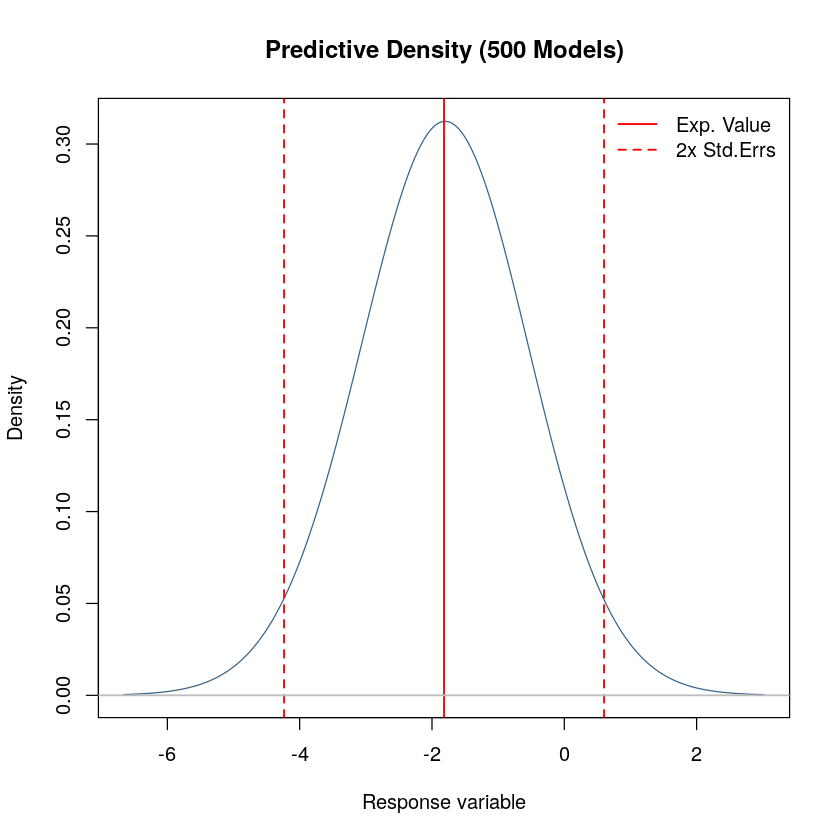

In [191]:
plot(pdens,1)
probs<-seq(-2,5,0.01)
pdens$dyf(probs)

Finally, the package also provides the mean log predictive density (MLPD).

In [192]:
pdens <- pred.density(bma, newdata = x.test)

lps.bma(pdens,matrix(y.test, ncol=1))

[1] 1.546713

### Reference model approach

#### Analytical

In [193]:
reference.model.anal<-function(x.train, y.train, original.x=x.train.data, reference.model = bma, extended = TRUE){  
    fit<-fit.reg.analytical(x.train, y.train, alpha, beta, extended=extended)
    seq.y<-seq(-5,5,0.1)
    KL<-0
    n<-dim(x.train)[1]
    for(i in 1:dim(x.train)[1]){ 
        # Reference density
        D.train <- matrix(original.x[i,], nrow=1)
        pdens <- pred.density(reference.model, newdata = D.train)
        p.reference<-pdens$dyf(seq.y)
        # Target density
        p.target<-get.prob.y.reg.anal(matrix(x.train[i,]), fit$V.s, 
                                       fit$mu.s, fit$alpha.s, fit$beta.s, 
                                       seq.y, extended = extended)
        # Remove NAN
        idx<-!is.na(p.target) & !is.na(p.reference)
        p.reference<-matrix(p.reference[idx])
        p.target<-matrix(p.target[idx])
        # KL divergence
        KL.new<-KLD(p.reference, p.target)$sum.KLD.px.py
        KL<-KL+KL.new
    }    
    return(KL/n) 
}

x.train.data<-x.train
KL<-reference.model.anal(x.train, y.train, reference.model = bma, extended = TRUE)
KL

[1] 0.1489668

In [207]:
opt<-optimization(x.train, y.train, reference.model.anal)

[1] "Starting optimization"
[1]  1  2  4  5 11 16 20 19 31


In [208]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 8

[1] 0.02238852

[1] "(Intercept)" "X1"          "X3"          "X4"          "X10"        
[6] "X15"         "X19"         "X18"         "X30"

In [211]:
opt$all.criteria

[1] 0.37415841 0.20344432 0.13927582 0.10645795 0.06946764 0.02315909
 [7] 0.02331759 0.02323167 0.02276099 0.02288015 0.02278620 0.02287330
[13] 0.02264933 0.02467362 0.02531703 0.02671414 0.02899135 0.03147787
[19] 0.03451720 0.03488656 0.03618046 0.03798113 0.04398463 0.05664675
[25] 0.05974847 0.06669454 0.07283175 0.08943779 0.11024493 0.11962291

In [212]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
fit<-fit.reg.analytical(x.train.model, y.train, alpha, beta)

performance<-MLPD.anal(x.test.model, y.test, nt, fit$V.s, fit$mu.s, fit$alpha.s, fit$beta.s)

performance

[1] 1.605

#### with STAN

In [67]:
reference.model<-function(x.train, y.train, original.x=x.train.data, reference.model = bma){

    linear.fit<-fit.linear.regression(x.train, y.train, alpha, beta, modelString.reg)
    omega.post<-linear.fit$omega.post
    sigma.post<-linear.fit$sigma.post
    seq.y<-seq(-5,5,0.1)
    KL<-0
    n<-dim(x.train)[1]
    for(i in 1:dim(x.train)[1]){ 
        # Reference density
        D.train <- matrix(original.x[i,], nrow=1)
        pdens <- pred.density(reference.model, newdata = D.train)
        p.reference<-pdens$dyf(seq.y)
        # Target density
        p.target<-get.y.probs.reg(matrix(x.train[i,]), omega.post, sigma.post, seq.y)
        # Remove NAN
        idx<-!is.na(p.target) & !is.na(p.reference)
        p.reference<-matrix(p.reference[idx])
        p.target<-matrix(p.target[idx])
        # KL divergence
        KL.new<-KLD(p.reference, p.target)$sum.KLD.px.py
        KL<-KL+KL.new
    }    
    return(KL/n)    
}

x.train.data<-x.train
KL<-reference.model.anal(x.train, y.train, reference.model = bma, extended = TRUE)
KL

[1] 0.2857493

In [ ]:
opt<-optimization(x.train, y.train, reference.model)

In [ ]:
opt$num.vars
opt$criteria
colnames(opt$model)

In [ ]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
linear.fit<-fit.linear.regression(x.train.model, y.train, alpha, beta, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post

performance<-MLPD(x.test.model, y.test, nt, sigma.pos, omega.pos)

performance

## 4. Experiments II: Classification <a name="ExpClass" ></a>

### MLPD classification

In [35]:
MLPD.class<-function(x.test, y.test, nt, post){#omega.pos){
    MLPD <- 0
    for(i in 1:nt){
        # Get probability density of different values of y
        D.test<-data.frame(x.test)
        p<-pred.prob.class(D.test[i,])
        if((p>0)*(p<1)){
            MLPD<-MLPD + log(p) + log(1.-p)
        }
        
    }
    MLPD<- - MLPD/nt
    return(MLPD)
}

In [36]:
# Example simulation experiment
# Define parameters
n <- 100
rho <- 0.5
p <- 30
chi <- 0.34
alpha<-0.5
beta<-0.5
nt<-1000

# Simulate observations
sim.train<-simulate.classification(n, rho, chi, p)
x.train<-sim.train$x
y.train<-sim.train$y

# Simulate observations
sim.test<-simulate.classification(nt, rho, chi, p)
x.test<-sim.test$x
y.test<-sim.test$y

# Get MLPD
# Fit linear model and generate posterior quantities
post<-fit.logit(x.train,y.train, alpha, beta)

performance<-MLPD.class(x.test, y.test, nt, post)

performance

[1] 2.259972

## Criterion 1: Cross-validation <a name="CVclass" ></a>

In [37]:
library(caret)

k.fold.cv.class<-function(x.train, y.train, k.fold=10){
    set.seed(10)
    partitions<-createFolds(y.train, k = k.fold, list = TRUE, returnTrain = FALSE)
    cv<-0
    for(i in 1:k.fold){
        idx<-unlist(partitions[i])
        x.fold.in<-as.matrix(x.train[idx,])
        y.fold.in<-y.train[idx]
        x.fold.out<-as.matrix(x.train[-idx,])
        y.fold.out<-y.train[-idx]
        post.fit.obj<-fit.logit(x.fold.out, y.fold.out, alpha, beta, return.cols = TRUE)
        post.fit<-post.fit.obj$post
        names<-post.fit.obj$names
        D.test<-data.frame(x.fold.in)
        colnames(D.test) <- colnames(D.test) <- names[2:length(names)]
        for(j in 1:length(idx)){ 
            # Target probability
            if(dim(D.test)[2]>1){
                p<-pred.prob.class(D.test[j,], model = post.fit)
            }
            else{
                p<-pred.prob.class(D.test, model = post.fit)
            }
            if((p>0)*(p<1)){
                cv<-cv + log(p) + log(1-p)
            }
        }
    }
    cv<- -cv/length(y.train)
    return(cv)
}

k.fold<-10

cv<-k.fold.cv.class(x.train, y.train, k.fold)

cv

[1] 2.455994

In [38]:
opt<-optimization(x.train, y.train, k.fold.cv.class, extended = FALSE)

[1] "Starting optimization"
[1]  1 29 25 27 17


In [39]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 4

[1] 1.660488

[1] "(Intercept)" "X1"          "X2"          "X3"          "X4"         
[6] "X5"

In [40]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
post<-fit.logit(x.train.model,y.train, alpha, beta)

performance<-MLPD.class(x.test.model, y.test, nt, post)

performance

[1] 1.838024

## Criterion 2: Widely applicable information criterion (WAIC) <a name="waicClass" ></a>

In [60]:
library(caret)

WAIC.model.class<-function(x.train, y.train, M=50){
    WAIC<-0
    post.fit.obj<-fit.logit(x.train, y.train, alpha, beta, return.cols = TRUE)
    post.fit<-post.fit.obj$post
    names<-post.fit.obj$names
    D.test<-data.frame(x.train)
    colnames(D.test) <- colnames(D.test) <- names[2:length(names)]
    for(i in 1:n){
        #Target probability
        if(dim(D.test)[2]>1){
        p<-pred.prob.class(D.test[i,], model = post.fit)
        }
        else{
        p<-pred.prob.class(D.test, model = post.fit)
        }       
        aux<-rep(0,M)
        cont<-1
        for(j in 1:M){
            post.fit.obj<-fit.logit(x.train, y.train, alpha, beta, return.cols = TRUE)
            post.fit<-post.fit.obj$post
            names<-post.fit.obj$names
            D.test<-data.frame(x.train)
            colnames(D.test) <- colnames(D.test) <- names[2:length(names)]
            if(dim(D.test)[2]>1){
            p2<-pred.prob.class(D.test[i,], model = post.fit)
            }
            else{
            p2<-pred.prob.class(D.test, model = post.fit)
            }
            aux[cont]<-log(p2)
            cont<-cont+1
        }
        variance<-var(aux)
        if((!is.na(WAIC + log(p)-variance))*is.finite(WAIC + log(p)-variance)){
            WAIC<-WAIC + (log(p) - variance)
        }
    }
    WAIC<-WAIC/length(y.train)
    return(-WAIC) #opposite sign since the optimization procedure minimizes
}

WAIC<-WAIC.model.class(x.train, y.train)

WAIC

[1] 1.639752

In [61]:
opt<-optimization(x.train, y.train, WAIC.model.class, extended = FALSE)

[1] "Starting optimization"
[1]  1 22 17 20 26 21 30 18 29


In [62]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 8

[1] 1.289909

[1] "(Intercept)" "X1"          "X2"          "X3"          "X4"         
 [6] "X5"          "X6"          "X7"          "X8"          "X9"

In [63]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
post<-fit.logit(x.train.model, y.train, alpha, beta)

performance<-MLPD.class(x.test.model, y.test, nt, post)

performance

[1] 1.998616

## Criterion 3: $L^2$ model approach <a name="L2class" ></a>

In [52]:
library(caret)

L2.model.class<-function(x.train, y.train, extended=TRUE){
    L2<-0
    post.fit.obj<-fit.logit(x.train,y.train, alpha, beta, return.cols = TRUE)
    post.fit<-post.fit.obj$post
    names<-post.fit.obj$names
    for(i in 1:n){
        D.test<-data.frame(x.train[i,])
        D.test<-as.data.frame(t(D.test[1]))
        colnames(D.test) <- names[2:length(names)]
        if(dim(D.test)[2]>1){
            p<-pred.prob.class(D.test[1,], model = post.fit)
        }
        else{
            p<-pred.prob.class(D.test, model = post.fit)
        }
        if((p>0)*(p<1)){
            expectation<-p
            variance<-p*(1-p)
            term<-(y.train[i]-expectation)^2+variance
            L2<-L2 + term
        }        
    }
    return(L2)    
}

L2<-L2.model.class(x.train, y.train, extended=FALSE)

L2

[1] 23.762

In [142]:
opt<-optimization(x.train, y.train, L2.model.class, extended = FALSE)

[1] "Starting optimization"
 [1]  1  9  3 27 13 19  7 22  8 10  4 24 29 28  5 30 26 17 11 20 14 21  6 18 15
[26] 23 12 16


In [143]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 27

[1] 21.548

[1] "(Intercept)" "X1"          "X2"          "X3"          "X4"         
 [6] "X5"          "X6"          "X7"          "X8"          "X9"         
[11] "X10"         "X11"         "X12"         "X13"         "X14"        
[16] "X15"         "X16"         "X17"         "X18"         "X19"        
[21] "X20"         "X21"         "X22"         "X23"         "X24"        
[26] "X25"         "X26"         "X27"         "X28"

In [144]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
post<-fit.logit(x.train.model, y.train, alpha, beta)

performance<-MLPD.class(x.test.model, y.test, nt, post)

performance

[1] 2.477661

## Criterion 4: Reference model approach <a name="refClass" ></a>

In [56]:
require("BMA")

bma.class<-bic.glm(y.train~., data = D.train, glm.family="binomial", factor.type=FALSE)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [113]:
reference.model.class<-function(x.train, y.train, original.x=x.train.data, reference.model = bma.class){  
    post.fit<-fit.logit(x.train,y.train, alpha, beta)
    seq.y<-seq(-5,5,0.1)
    KL<-0
    n<-dim(x.train)[1]
    # Reference prediction
    pdens <- predict(reference.model, original.x)   
    D.train<-data.frame( x.train)
    for(i in 1:dim(x.train)[1]){ 
        # Reference probability       
        p.reference<-pdens[i]
        # Target probability
        if(dim(D.train)[2]>1){
            p.target<-pred.prob.class(D.train[i,], model = post.fit)
        }
        else{
            p.target<-pred.prob.class(D.train, model = post.fit)
        }
        # KL divergence
        if((p.reference>0)*(p.reference<1)*(p.target>0)*(p.target<1)){
            KL.new<-p.reference*log(p.reference/p.target) + (1-p.reference)*log((1-p.reference)/(1-p.target))
            KL<-KL+KL.new
        }
    }    
    return(KL/n) 
}

x.train.data<-x.train
KL<-reference.model.class(x.train, y.train, original.x=x.train.data, reference.model = bma.class)
KL

2 
0.2441226

In [114]:
opt<-optimization(x.train, y.train, reference.model.class, extended = FALSE)

[1] "Starting optimization"


In [115]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 3

1 
0.03765777

[1] "(Intercept)" "X1"          "X2"          "X3"          "X4"

In [116]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
post<-fit.logit(x.train.model,y.train, alpha, beta)

performance<-MLPD.class(x.test.model, y.test, nt, post)

performance

[1] 2.218411

## 5. Analysis of the results <a name="AnalysisResults" ></a>

After having performed the different experiments in regression and classification problems, we assess the results. In particular we will look at the number of variables chosen by each of the criteria and also at the final performance of the optimal model, according to each of the criterion. This final performance will be evaluated using the MLPD utility. 

### Selected variables <a name="SelVariables" ></a>

<center>REGRESSION TASK</center>   
<img src="Images/table_regression.png" alt="table_17" width="700"/>

<center>CLASSIFICATION TASK</center>
<img src="Images/table_regression.png" alt="table_17" width="700"/>

### Performance <a name="Performance" ></a>

In [64]:
crit<-c("CV", "WAIC", "L2", "Reference", "CV", "WAIC", "L2", "Reference")

perf.reg<-c(1.594, 1.537 ,1.548, 1.605)

perf.class<-c(1.838,2.000,2.478, 2.218)

perf<-c(perf.reg, perf.class)
type<-c(rep("Regression",4), rep("Classification",4))
data <- data.frame(perf, type, crit)

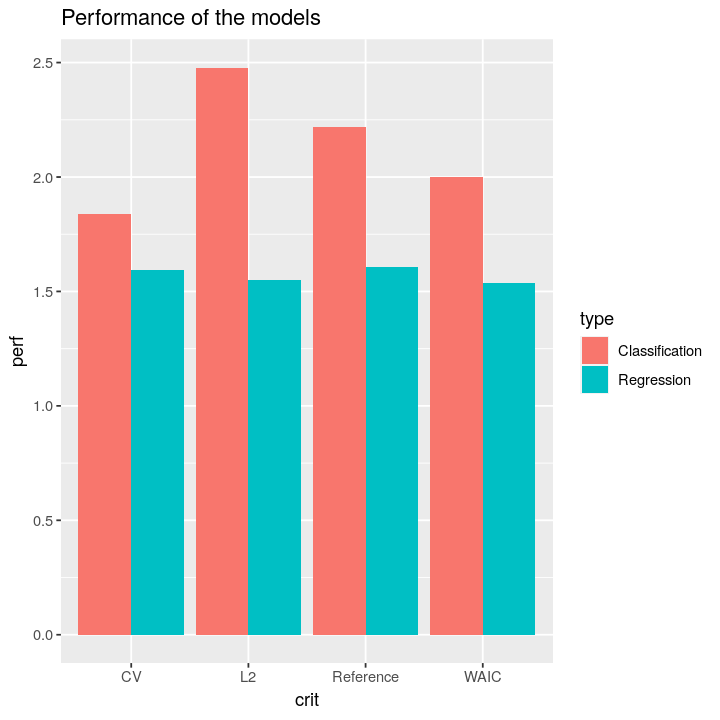

In [65]:
library(ggplot2)

ggplot(data, aes(fill=type, y=perf, x=crit)) + 
    geom_bar(position="dodge", stat="identity") +
    ggtitle("Performance of the models") 

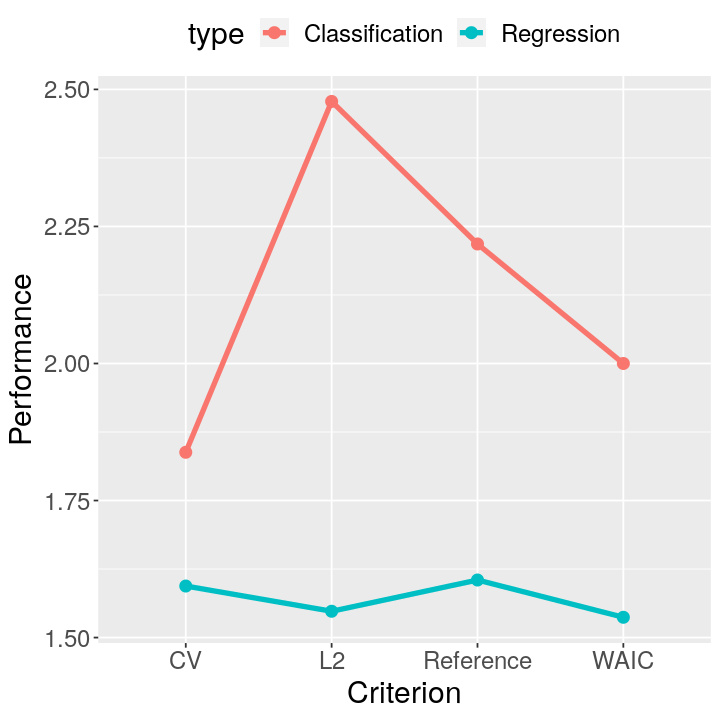

In [66]:
ggplot(data, aes(group=type, y=perf, x=crit)) +
  geom_line(aes(color=type), size=1.5) +
  geom_point(aes(color=type), size=3) +
  theme(legend.position="top", text = element_text(size=18)) +
  xlab("Criterion") + ylab("Performance")